In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import joblib


Pneumonia DataSet

In [2]:
labels = ["PNEUMONIA","NORMAL"]
img_resize = 150

def get_data(dir):
    data =[]
    for label in labels:
        path = os.path.join(dir,label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                if img.endswith('.jpeg'):
                    img_arr = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr,(img_resize,img_resize))
                    data.append([resized_arr,class_num])
            except Exception as e:
                print(f"Error {e}")
    return np.array(data,dtype="object")


In [3]:
train = get_data('../data/chest_xray/train')
test = get_data('../data/chest_xray/test')
val = get_data('../data/chest_xray/val')

In [4]:
print(f"The length of train dataset is {len(train)}")
print(f"The length of test dataset is {len(test)}")
print(f"The length of val dataset is {len(val)}")

The length of train dataset is 4187
The length of test dataset is 624
The length of val dataset is 1045


Data Visualization and Preprocessing

<Axes: xlabel='count'>

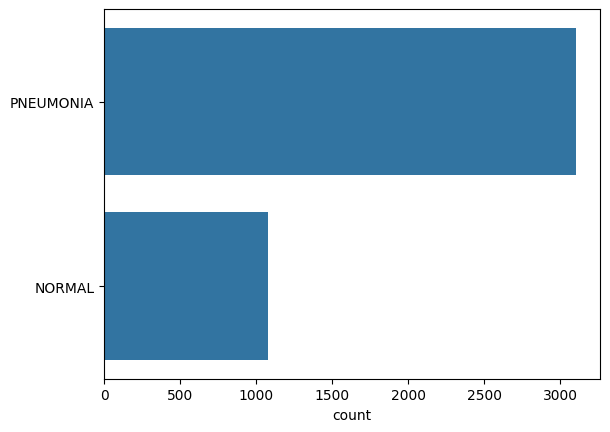

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append('PNEUMONIA')
    else:
        l.append("NORMAL")
sns.countplot(l)

Text(0.5, 1.0, 'PNEUMONIA')

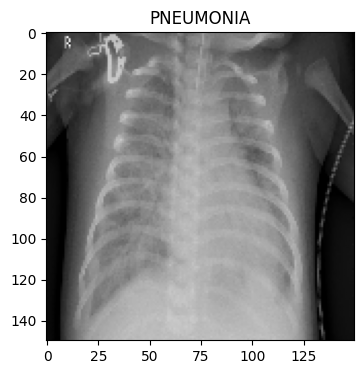

In [6]:
plt.figure(figsize=(4,4))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'NORMAL')

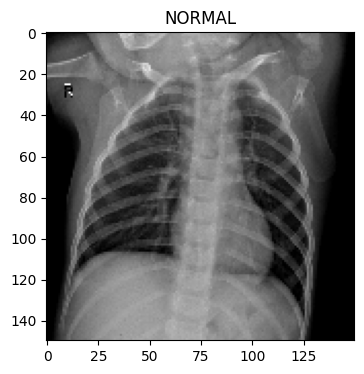

In [7]:
plt.figure(figsize=(4,4))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [8]:
x_train =[]
y_train = []

x_val=[]
y_val =[]

x_test =[]
y_test = []

for feat, label in train:
    x_train.append(feat)
    y_train.append(label)

for feat, label in val:
    x_val.append(feat)
    y_val.append(label)

for feat, label in test:
    x_test.append(feat)
    y_test.append(label)



Normalize the data

In [9]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255


In [10]:
x_train = x_train.reshape(-1,img_resize, img_resize,1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1,img_resize,img_resize,1)
y_val = np.array(y_val)


x_test = x_test.reshape(-1,img_resize,img_resize,1)
y_test = np.array(y_test)

Data Augmentation

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(x_train)

Training the model

In [12]:
model = Sequential()
model.add(Conv2D(32,(3,3), strides =1, padding='same', activation='relu', input_shape=(150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64,(3,3), strides =1, padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(64,(3,3), strides =1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(128,(3,3), strides =1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Conv2D(256,(3,3), strides =1, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2),strides=2,padding='same'))
model.add(Flatten())
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']) 
model.summary()

d:\ML projects\models\pneumonia detection cnn\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.3,min_lr=0.000001)


In [14]:
history = model.fit(x_train,y_train,batch_size=32,epochs=18,
                    validation_data=datagen.flow(x_val,y_val),
                    callbacks=[learning_rate_reduction])

Epoch 1/18
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.8382 - loss: 0.9511

d:\ML projects\models\pneumonia detection cnn\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 94s 691ms/step - accuracy: 0.9033 - loss: 0.3658 - val_accuracy: 0.7426 - val_loss: 3.1902 - learning_rate: 0.0010
Epoch 2/18
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 672ms/step - accuracy: 0.9632 - loss: 0.1031 - val_accuracy: 0.7426 - val_loss: 3.4031 - learning_rate: 0.0010
Epoch 3/18
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.9718 - loss: 0.0746
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 671ms/step - accuracy: 0.9706 - loss: 0.0763 - val_accuracy: 0.7426 - val_loss: 6.7483 - learning_rate: 0.0010
Epoch 4/18
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 673ms/step - accuracy: 0.9852 - loss: 0.0459 - val_accuracy: 0.7426 - val_loss: 3.1305 - learning_rate: 3.0000e-04
Epoch 5/18
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 666ms/step - accuracy: 0.9897 - loss: 0.0305 - val_accuracy: 0.7445 - val_loss: 2.9992 - learning_rate: 3.0000e-04
Epoch 6/18
131/131 ━━━━━━━━━━━━━━━━━━━━ 91s 697ms/step - accuracy: 0.9907 -

In [28]:
model.save("pneumonia_model.h5")

In [17]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Loss of the model is {loss:.4f}")
print(f"Accuracy of the model is {accuracy*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.7244 - loss: 2.5588
Loss of the model is 2.5588
Accuracy of the model is 72.44%


Analyse Model Perfomance

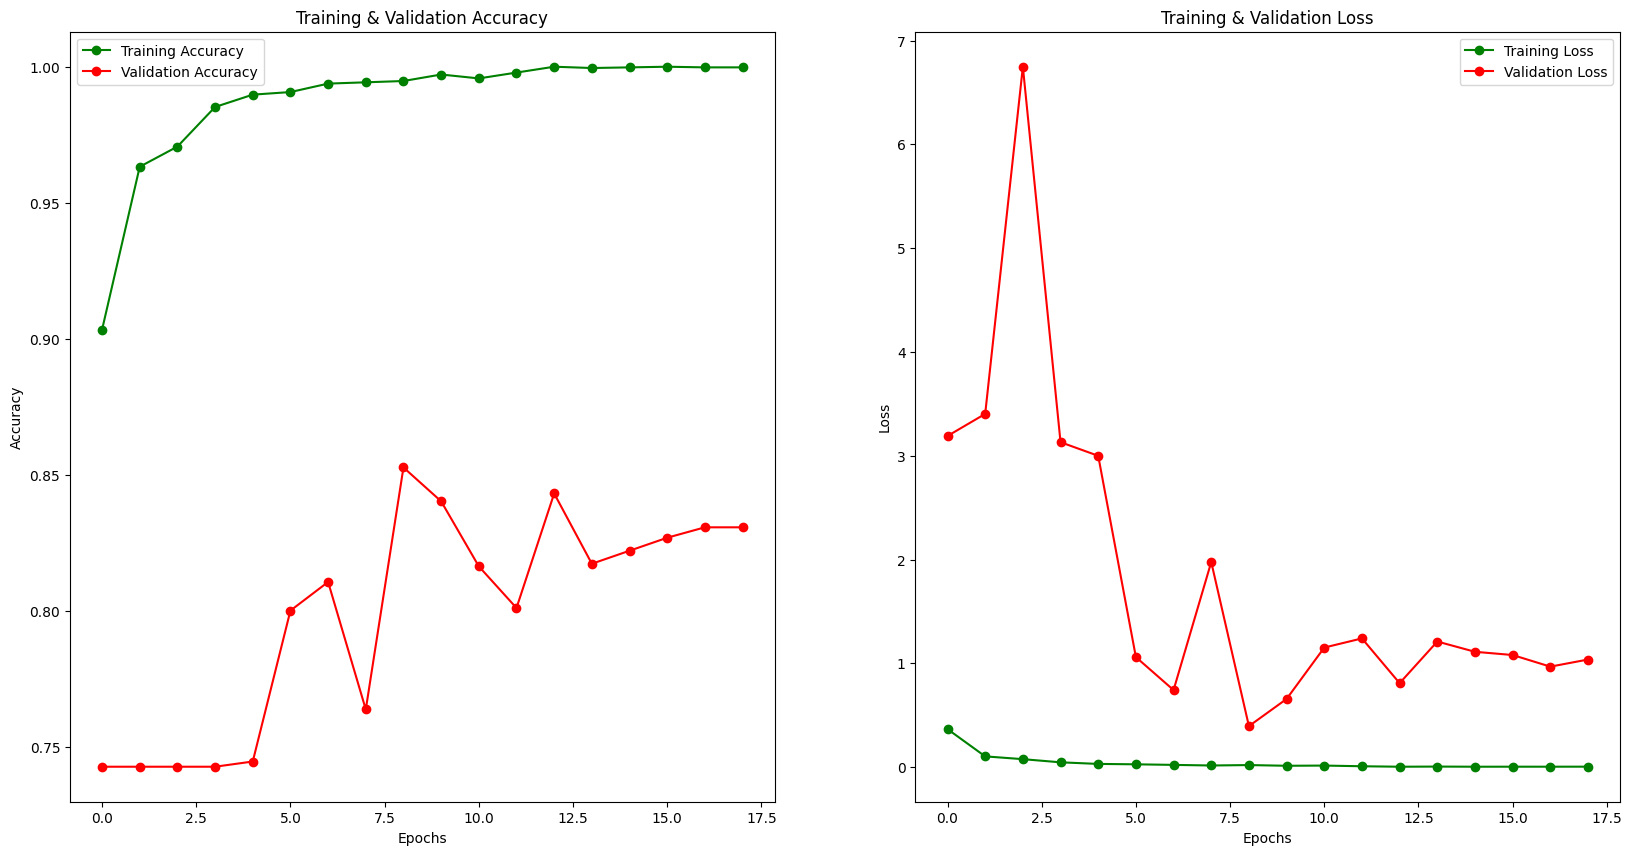

In [18]:
epochs = [i for i in range(18)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,10)

ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')


ax[1].plot(epochs, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
plt.show()
     

In [19]:
predictions = (model.predict(x_test) > 0.5).astype('int32')
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [20]:
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.69      1.00      0.82       390
   Normal (Class 1)       1.00      0.26      0.42       234

           accuracy                           0.72       624
          macro avg       0.85      0.63      0.62       624
       weighted avg       0.81      0.72      0.67       624



In [21]:
cm = confusion_matrix(y_test,predictions)

In [22]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

Some Correctly Predicted Classes

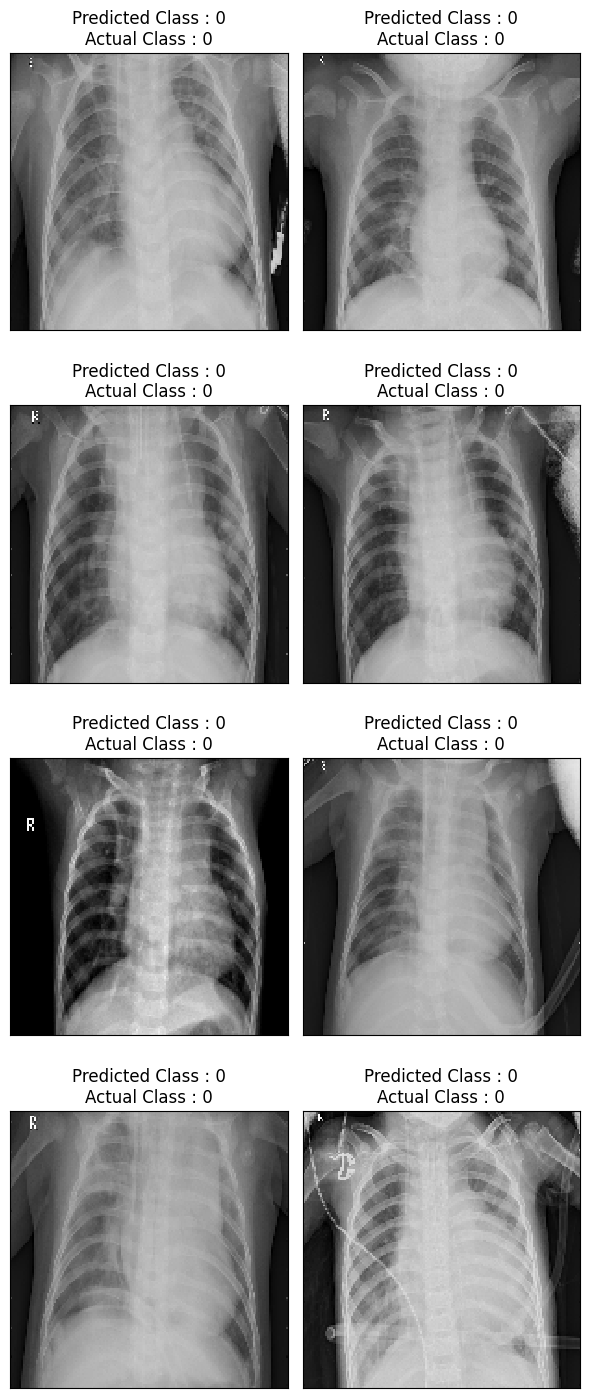

In [23]:
i = 0
plt.figure(figsize=(6,15))
for c in correct[10:18]:
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(150,150), cmap='gray', interpolation='none')
  plt.title(f"Predicted Class : {predictions[c]}\nActual Class : {y_test[c]}")
  plt.tight_layout()
  i += 1

Some Incorrectly Predicted Classes

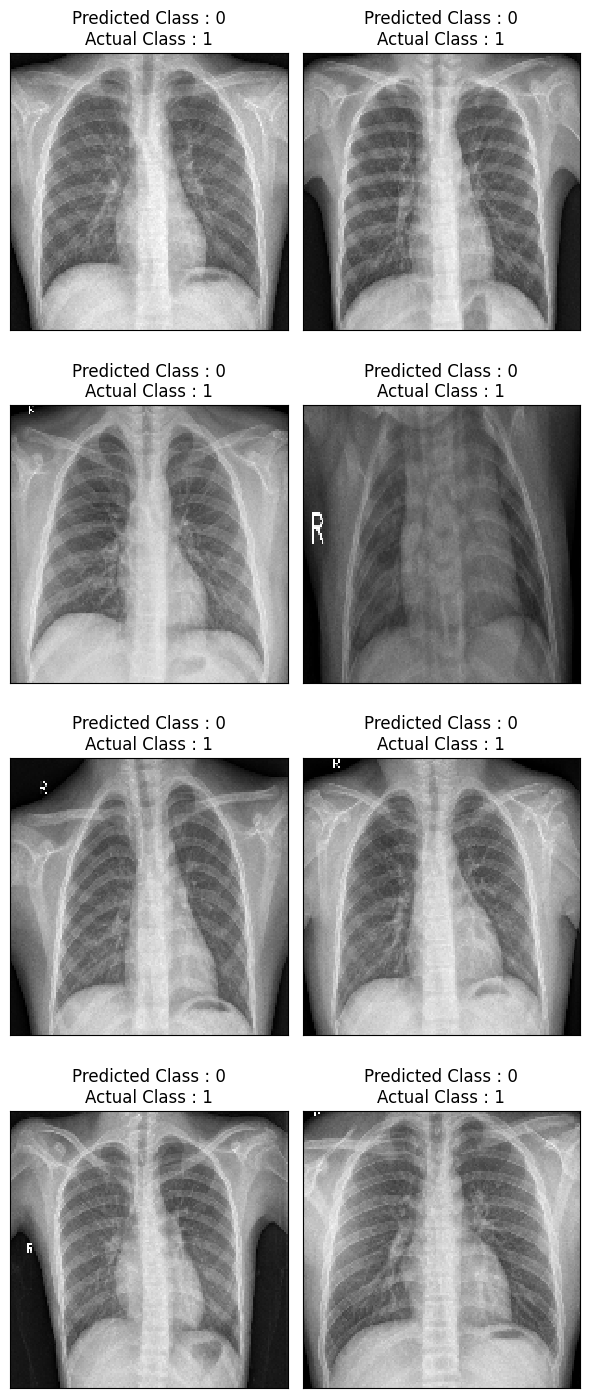

In [24]:

i = 0
plt.figure(figsize=(6,15))
for c in incorrect[10:18]:
  plt.subplot(4,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(150,150), cmap='gray', interpolation='none')
  plt.title(f"Predicted Class : {predictions[c]}\nActual Class : {y_test[c]}")
  plt.tight_layout()
  i += 1